In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [70]:

from src.catalogs import (
    JapanSlowSlipCatalog,
    MexicoSlowSlipCatalog, 
    XieSlowSlipCatalog,
    WilliamsSlowSlipCatalog,
    MichelSlowSlipCatalog,   # too few earthquakes to estaplish rate changes 
    OkadaAlaskaSlowSlipCatalog,
)

from src.data import (
    AllSlabs, 
    Catalog,
    EarthquakeCatalog,
    Scaling,
)

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import string
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import gaussian_kde, kstest

from typing import Union

import src
from pathlib import Path
base_dir = Path(src.__file__).parents[1]

dpi = 200
mpl.rc('figure',dpi=dpi)
plt.style.use('tableau-colorblind10')
mpl.rc('font',size=9)
figure_save_dir = base_dir/'Docs'/'Figures_SCEC'
save_figures = True
def savefig(fig_name, save_fig_bool = save_figures):
    plt.savefig(figure_save_dir/f'{fig_name}.pdf', transparent=True,bbox_inches='tight')

# Global analysis of slow slip

## Datasets

`AllSlabs` loads in all the slab geometries from Slab2.0

`EarthquakeCatalog` loads the global Comcat catalog. The first time running this will take a long time (a few minutes).

In [3]:
all_slabs = AllSlabs()

minimum_magnitude = 4.0

metadata = {
    "starttime": '1994-01-01',
    "endtime": '2023-01-01',
    "latitude_range": [-90,90],
    "longitude_range": [-180,180],
    "minimum_magnitude":minimum_magnitude 
}

earthquakes = EarthquakeCatalog(
    filename=base_dir / "Datasets" / "Seismicity_datasets" / "global_earthquakes.csv",
    kwargs=metadata,
)

/Users/kdascher/Documents/Documents - Kelian’s MacBook Pro/Projects/Slow_slip_meta_analysis/src/data/earthquake.py:179: UserWarning: Using existing /Users/kdascher/Documents/Documents - Kelian’s MacBook Pro/Projects/Slow_slip_meta_analysis/Datasets/Seismicity_datasets/global_earthquakes.csv
  warnings.warn(f"Using existing {filename}")
/Users/kdascher/Documents/Documents - Kelian’s MacBook Pro/Projects/Slow_slip_meta_analysis/src/data/earthquake.py:185: UserWarning: 486 NaN values found in catalog. Removing rows with NaN values.
  warnings.warn(


## Configurable parameters

In [4]:
DEPTH_SUBSET = 'all'
assert DEPTH_SUBSET in ['deep','shallow','all']

DURATION_SUBSET = 'all'
assert DURATION_SUBSET in ['short term', 'long term', 'all']

SLOWSLIP_MAGNITUDE_CUTOFF = 5.0
assert type(SLOWSLIP_MAGNITUDE_CUTOFF) is float

# Duplicate filtering
DUPLICATE_RADIUS = 70
DUPLICATE_TIME = 40

# Spatio-temporal emporal analysis:
TIME_WINDOW = 365 # days
SMOOTHING_BANDWIDTH_DAYS = 5 # days

SPACE_WINDOW_BIG = 2000 # km for spatial stack
DISTANCE_TO_SLAB = 20 # km 

IMPUTE_DURATION = True
REPRESENTATIVE_SSE_SIZE = 100 # km for temporal stack

BACKGROUND_DURATION = 365

MIN_NUMBER_OF_EVENTS_FOR_RATE_CHANGE = 4

# Sensitivity tests and benchmarks:
NEARBY_EQ_DISTANCE = 20


## Slow slip datasets and pre-processing

* depth 
* duration
* magnitude
* duplicates

In [5]:
# Consider depth subsets THIS CURRENTLY RELOADS THE DATA!!
if DEPTH_SUBSET == 'shallow':
    shallow_slowslip = [
        JapanSlowSlipCatalog().get_ryukyu_trench().get_clusters('depth',2)[0],
        JapanSlowSlipCatalog().get_japan_trench().get_clusters('depth',2)[0],
        XieSlowSlipCatalog().get_clusters('depth',2)[0],
        WilliamsSlowSlipCatalog().get_clusters('depth',2)[0],
        OkadaAlaskaSlowSlipCatalog.get_clusters('depth',2)[0],
    ]

    slowslip = shallow_slowslip

elif DEPTH_SUBSET == 'deep':
    deep_slowslip = [
        JapanSlowSlipCatalog().get_nankai_trough().get_clusters('depth',2)[1],
        JapanSlowSlipCatalog().get_ryukyu_trench().get_clusters('depth',2)[1],
        JapanSlowSlipCatalog().get_japan_trench().get_clusters('depth',2)[1],
        MexicoSlowSlipCatalog(), 
        XieSlowSlipCatalog().get_clusters('depth',2)[1],
        WilliamsSlowSlipCatalog().get_clusters('depth',2)[1],
        MichelSlowSlipCatalog(),
        OkadaAlaskaSlowSlipCatalog.get_clusters('depth',2)[1],
    ]
    
    slowslip = deep_slowslip

elif DEPTH_SUBSET == 'all':
    slowslip = [
        JapanSlowSlipCatalog().get_nankai_trough(),
        JapanSlowSlipCatalog().get_ryukyu_trench(),
        JapanSlowSlipCatalog().get_japan_trench(),
        MexicoSlowSlipCatalog(), 
        XieSlowSlipCatalog(),
        WilliamsSlowSlipCatalog(),
        MichelSlowSlipCatalog(),
        OkadaAlaskaSlowSlipCatalog(),
    ]
        
# Consider magnitude cutoff
for ss in slowslip:
    ss.mag_completeness = SLOWSLIP_MAGNITUDE_CUTOFF # changing in place

# Consider different duration types of SSEs
if DURATION_SUBSET == 'short term':
    slowslip = [ss.get_short_term_events() for ss in slowslip]
elif DURATION_SUBSET == 'long term':
    slowslip = [ss.get_long_term_events() for ss in slowslip] 

slowslip = [ss for ss in slowslip if len(ss)>0]
all_slowslip = sum(slowslip[1:], slowslip[0])

# Consider unique events
filter_kwargs = dict(
    buffer_radius_km = DUPLICATE_RADIUS,
    buffer_time_days = DUPLICATE_TIME,
    stategy='reference',
)

all_slowslip = all_slowslip.filter_duplicates(
    **filter_kwargs,
    ref_preference = all_slowslip.catalog.groupby('ref').max().time.sort_values(ascending=False).index
)

slowslip_filtered = []
for s in slowslip:
    slowslip_filtered.append(s.filter_duplicates(**filter_kwargs, ref_preference=s.catalog.groupby('ref').max().time.sort_values(ascending=False).index))

slowslip = slowslip_filtered
slowslip = sorted(slowslip, key=lambda x: len(x), reverse=True)
for s in slowslip:
    s.catalog['name'] = s.name 
    s.catalog['region'] = s.region
all_slowslip = sum(slowslip[1:], slowslip[0])

# Impute durations:
if IMPUTE_DURATION is True:
    for ss in slowslip: 
        ss.impute_duration(
            mag=all_slowslip.catalog.mag,
            duration=all_slowslip.catalog.duration,
        )
    all_slowslip.impute_duration()
            

/var/folders/nl/dmjw3blj27nd4c04v3dxnqw40000gn/T/ipykernel_43255/2706975650.py:61: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  ref_preference = all_slowslip.catalog.groupby('ref').max().time.sort_values(ascending=False).index
/var/folders/nl/dmjw3blj27nd4c04v3dxnqw40000gn/T/ipykernel_43255/2706975650.py:66: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  slowslip_filtered.append(s.filter_duplicates(**filter_kwargs, ref_preference=s.catalog.groupby('ref').max().time.sort_values(ascending=False).index))


Chen et al. (2018)
Cruz-Atienza et al. (2021)
El Yousfi et al. (2022)
Graham et al. (2016)
Itaba et al. (2013a)
Itaba et al. (2013b)
Itaba et al. (2014a)
Itaba et al. (2014b)
Itaba et al. (2015)
Ito et al. (2013)
Kitagawa et al. (2012)
Kostoglodov (2003)
Lou et al. in prep.
Lowry et al. (2001)
Michel et al. 2018
Nishimura (2013)
Nishimura (2014)
Nishimura (2021)
Ochi et al. (2015)
Ochi et al. (2016)
Okada et al. (2022)
Okada et al. (2023)
Radiguet et al. (2011)
Radiguet et al. (2016)
Rousset et al. 2017
Sekine et al. (2010)
Takagi et al. (2016)
Takagi et al. (2022)
Williams et al., in prep.
Xie et al. (2020)
Yano and Kano (2022)

Depth clusters (km):
11.935194819612168
27.590160572593803
45.015854316158276


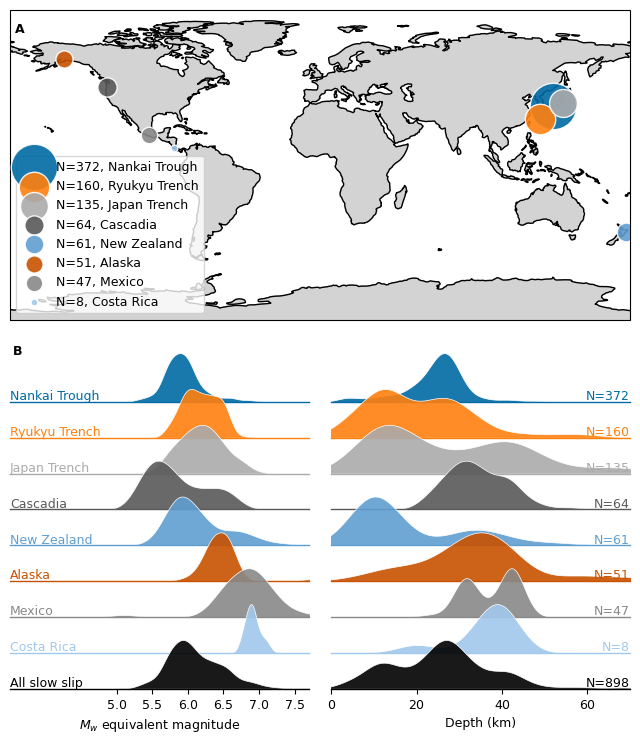

In [6]:
fig = plt.figure(figsize=(8,9))

gs0 = mpl.gridspec.GridSpec(2, 1,  hspace=0.05)

# Map:
ax0 = fig.add_subplot(gs0[0], projection=ccrs.PlateCarree())
extent = [-180,180,-90,90]
ax0.set_extent(extent,crs=ccrs.PlateCarree(),)
ax0.add_feature(cfeature.LAND, color="lightgray")
# ax0.add_feature(cfeature.OCEAN)
ax0.add_feature(cfeature.COASTLINE)

for i_slowslip in slowslip:
    ax0.scatter(
        np.mean(i_slowslip.catalog.lon),
        np.mean(i_slowslip.catalog.lat),
        s=len(i_slowslip)*3,
        edgecolor='w',
        label=f"N={len(i_slowslip)}, {i_slowslip.region}",
        zorder=10,
        alpha=0.9
    )
ax0.legend()

# Two colomns of ridgelin plots:
gs01 = mpl.gridspec.GridSpecFromSubplotSpec(len(slowslip)+1, 2, subplot_spec=gs0[1], hspace=-0.3, wspace=0.075)

def clean_ax(ax):
    ax.set(
        yticks=[],
        xticks=[],
        ylabel='',
        xlabel='',
        xticklabels=[],
    )
    rect = ax.patch
    rect.set_alpha(0)
    spines = ["top","right","left","bottom"]
    for s in spines:
        ax.spines[s].set_visible(False)

mag_AX = []
depth_AX = []
for i,ss in enumerate(slowslip+[all_slowslip]):
    shared_kwargs = dict(
        data=ss.catalog,
        color=f"C{i}" if i<len(slowslip) else 'k',
        linewidth=0.5,
        edgecolor='w',
        alpha=0.9,
        clip_on=True,
        fill=True,
    )

    mag_AX.append(fig.add_subplot(gs01[i, 0]))
    ax = mag_AX[-1]
    
    sns.kdeplot(
        x='mag',
        **shared_kwargs,
        ax=ax,
    )
    ax.axhline(0, color=f"C{i}" if i<len(slowslip) else 'k',lw=1, clip_on=False)

    ax.set_xlim(3.5,max(all_slowslip.catalog.mag))

    
    depth_AX.append(fig.add_subplot(gs01[i, 1]))
    ax = depth_AX[-1]
    
    sns.kdeplot(
        x='depth',
        ax=ax,
        **shared_kwargs,
    )
    ax.axhline(0, color=f"C{i}" if i<len(slowslip) else 'k',lw=1, clip_on=False)
    ax.set_xlim(0,70)
    
    [clean_ax(ax) for ax in [mag_AX[-1], depth_AX[-1]]]    


for i in range(len(slowslip)+1):
    ax = mag_AX[i]
    ax.text(
        0, 
        0.04, 
        slowslip[i].region if i<len(slowslip) else 'All slow slip', 
        color=ax.lines[-1].get_color() if i<len(slowslip) else 'k',
        transform=ax.transAxes, 
        ha='left'
    )
    
    ax = depth_AX[i]
    ax.text(        
        1, 
        0.04,
        f"N={len(slowslip[i])}" if i<len(slowslip) else f"N={len(all_slowslip)}",
        color=ax.lines[-1].get_color() if i<len(slowslip) else 'k',
        transform=ax.transAxes, 
        ha='right'
    )
    
ax = depth_AX[-1]
xticks = [0,20,40,60]
ax.set(xticks=xticks, xticklabels=xticks, xlabel='Depth (km)')

ax = mag_AX[-1]
xticks = np.arange(5,8,0.5)
ax.set(xticks=xticks, xticklabels=xticks, xlabel='$M_w$ equivalent magnitude');

for n, ax in enumerate([ax0,mag_AX[0]]):
    pos = [0.008, 0.925]
    ax.text(*pos, string.ascii_uppercase[n], transform=ax.transAxes, weight='bold')

savefig('global_map')

[print(ref) for ref in all_slowslip.catalog.ref.sort_values().unique()];

print("\nDepth clusters (km):")
[print(np.mean(c.catalog.depth)) for c in all_slowslip.get_clusters('depth',3)];

In [40]:
all_slowslip.catalog.time.min().year

1994

Slow slip event magnitude is 6.10864909553526 +/- [-0.0257404   0.02519398]
Start time: 1994-12-29 00:00:00
End time: 2021-01-14 00:00:00


[Text(0, 0.5, 'Number of events')]

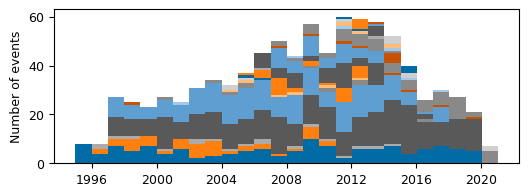

In [46]:
def bootstrap_ci(df,col,stat_fun=np.mean, ci=0.95,n=10000):
    assert ci <= 1
    stat = []
    for _ in range(n):
        stat.append(
            stat_fun(
                df[col].sample(len(df),replace=True).values
            )
        )
    return np.quantile(stat, [0.5-ci/2, 0.5+ci/2])

mean_mag = all_slowslip.catalog.mag.mean()
ci = bootstrap_ci(all_slowslip.catalog,'mag')
print(f"Slow slip event magnitude is {mean_mag} +/- {ci-mean_mag}")
print('Start time:', all_slowslip.start_time)
print('End time:', all_slowslip.end_time)

fig, ax = plt.subplots(figsize=(6,2))
times_by_study = [
    all_slowslip.catalog.time[all_slowslip.catalog.ref==iref].values 
    for iref in all_slowslip.catalog.ref.unique()
]

ax.hist(times_by_study,bins=26, histtype='barstacked');
ax.set(
    ylabel='Number of events'
)


## Analysis

In [7]:
local_earthquakes = earthquakes.intersection(all_slowslip,buffer_radius_km=SPACE_WINDOW_BIG)
distance_to_slab = all_slabs.distance(
    local_earthquakes.catalog[["lat","lon","depth"]].values,
    depth_unit="km",
    distance_unit="km",
)
local_earthquakes = EarthquakeCatalog(local_earthquakes.catalog.loc[distance_to_slab < DISTANCE_TO_SLAB])

/Users/kdascher/Documents/Documents - Kelian’s MacBook Pro/Projects/Slow_slip_meta_analysis/src/data/slab2.py:138: UserWarning: xyz contains negative depths
  warnings.warn("xyz contains negative depths")


## Global stacking

### Time stacks

In [8]:
def center_sequences(
    slowslipevents: Catalog = all_slowslip,
    earthquakes: Catalog = local_earthquakes,
    time_window: Union[float,np.ndarray] = TIME_WINDOW,
    space_window: float = REPRESENTATIVE_SSE_SIZE,
    lag = 0,
    slab_model=all_slabs,
    concatenate_output: bool = True,
    return_indices: bool = False,
    use_durations: bool = True,
    use_dimensions: bool = True,
):
        
    return src.center_sequences(
        slowslipevents=slowslipevents,
        earthquakes=earthquakes,
        time_window=time_window,
        space_window=space_window,
        lag=lag,
        slab_model=slab_model,
        concatenate_output=concatenate_output,
        return_indices=return_indices,
        use_durations = use_durations,
        use_dimensions= use_dimensions,
    )

Propotion of M6.0 within 20 km from SSEs and 100 days: 18.963636363636365


<GeoAxesSubplot: xlabel='Longitude', ylabel='Latitude'>

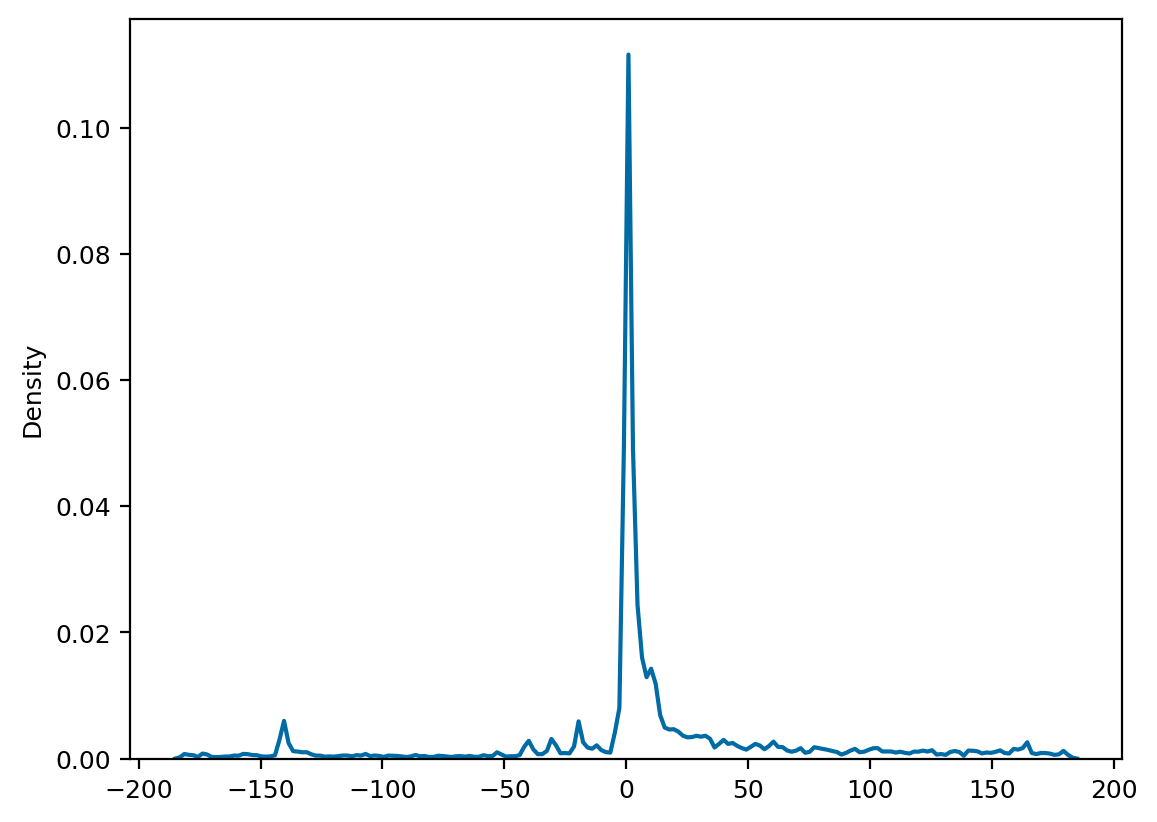

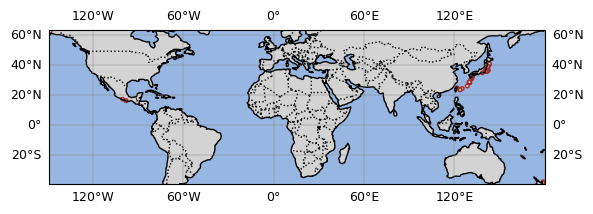

In [15]:
distance=NEARBY_EQ_DISTANCE
very_local_earthquakes =  earthquakes.intersection(all_slowslip,buffer_radius_km=distance)
distance_to_slab = all_slabs.distance(
    very_local_earthquakes.catalog[["lat","lon","depth"]].values,
    depth_unit="km",
    distance_unit="km",
)
very_local_earthquakes = EarthquakeCatalog(very_local_earthquakes.catalog.loc[distance_to_slab < DISTANCE_TO_SLAB])
big_local_earthquakes = very_local_earthquakes.slice_by('mag',6)
dt, dx, w = center_sequences(slowslipevents=big_local_earthquakes, use_durations=False)

fig, ax = plt.subplots(dpi=200)
sns.kdeplot(dt,ax=ax, bw_adjust=0.1)


dt, dx, w = center_sequences(earthquakes=big_local_earthquakes)
print(f'Propotion of M{big_local_earthquakes.mag_completeness} within {distance} km from SSEs and 100 days: {len(dt)/len(big_local_earthquakes)}')
big_local_earthquakes.plot_map()

In [167]:
def get_p_relative_to_back(
    slowslipevents = all_slowslip,
    earthquakes = local_earthquakes,
    event_duration = REPRESENTATIVE_SSE_DURATION,
    buffer_dutation = BUFFER_TIME,
    background_duration = BACKGROUND_DURATION,
    radius_km = REPRESENTATIVE_SSE_SIZE, 
    return_time_lags = True,
    number_samples = 1000,
):

    T_event = event_duration
    buffer = buffer_dutation
    T_pre = background_duration 
    R = radius_km

    pre_time_lags, buffer_time_lags, co_time_lags = [
        center_sequences(slowslipevents, earthquakes, time_window=T,space_window=R,lag=L, concatenate_output=False)[0]
        for T, L in zip(
            [T_pre, buffer, T_event],
            [-T_pre/2 - T_event/2 - buffer, -T_event/2-buffer/2, 0],
        )
    ]

    p_values = []

    for pre, co in zip(pre_time_lags, co_time_lags):
        N_baseline = []
        
        for _ in range(number_samples):
            random_window_start_time = np.random.uniform(
                -T_pre - T_event/2 - buffer,
                -T_event/2 - buffer - T_event # -T_event because we want to avoid the event itself
            )
            
            # count number times in pre that are in the range [random_window_start_time, random_window_start_time + T_event]
            N_baseline.append(
                np.sum(
                    (pre > random_window_start_time) & (pre < random_window_start_time + T_event)
                )
            )
        eps = 0 # perturb the baseline by a small amount such that window is the same number of events are divied up equally
        p_values.append(
            np.mean(
                len(co) <= np.array(N_baseline)  + np.random.uniform(-eps,eps,len(N_baseline))
            )
        )

    p_values = np.array(p_values)
    
    if return_time_lags:
        return p_values, pre_time_lags, buffer_time_lags, co_time_lags
    else:
        return p_values

## Temporal stacking

In [48]:
# lazy way of doing this...
raw_global_relative_times, raw_global_relative_distances, raw_global_weights, raw_global_Indices = center_sequences(
    time_window=7, concatenate_output=False, return_indices=True
)
global_relative_times, global_relative_distances, global_weights = center_sequences(
    time_window=7
)


regional_relative_times = []
regional_relative_distances = []
regional_weights = []
regionalized_weights = []
regional_window_indices = []

for region in slowslip:
    dt, dx, w, I = center_sequences(region,time_window=7, return_indices=True)
    regional_relative_times.append(dt)
    regional_relative_distances.append(dx)
    regional_weights.append(w)
    regionalized_weights.append(w/len(w))
    regional_window_indices.append(I)
    
combined_regional_relative_times = np.concatenate(regional_relative_times)
regionalized_weights = np.concatenate(regionalized_weights)
    

In [45]:
def add_gbar(ax,v, cmap='RdBu_r'):
    cax = ax.inset_axes([0.01, 0.7, 0.2, 0.2])
    cb = fig.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax, cax=cax, orientation='horizontal', fraction=1, aspect=20)
    cb.ax. plot(v,0.5, 'k', marker='o',markersize=2.5)
    cb.ax.set(
        xticks=[],
    )
    return cb

Text(0.5, 0, 'Number of earthquakes in slow slip window')

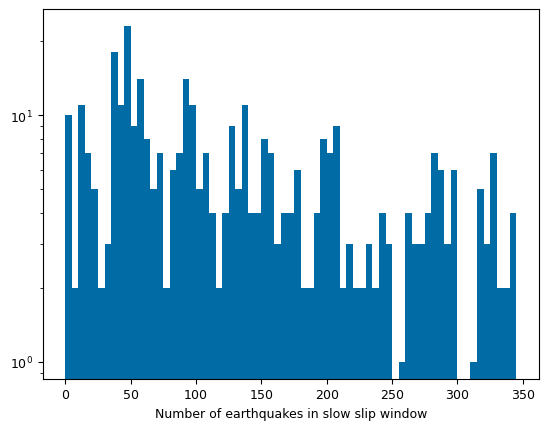

In [46]:
counts = np.array([len(s) for s in raw_global_relative_times])
bins = np.arange(0,350,5)
plt.hist(counts, log=True,bins=bins)
plt.xlabel('Number of earthquakes in slow slip window')


[Text(0.5, 0, 'Average background rate'), Text(0, 0.5, 'N_SSE')]

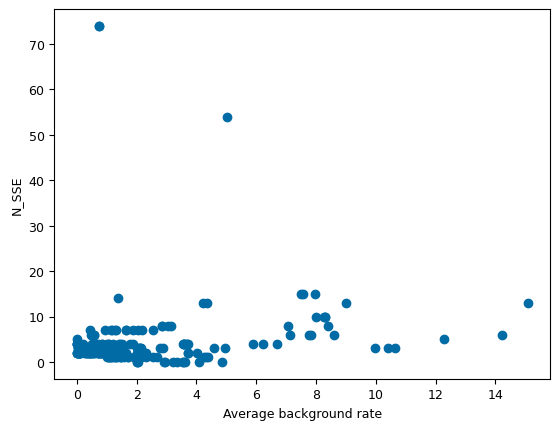

In [118]:
def in_vs_out(n_samples = 1000, sse=all_slowslip, t=raw_global_relative_times, T=TIME_WINDOW, buffer=30, n_samples_back=100,):
    N_SSE = []
    N_0 = []
    r = []

    for _ in range(n_samples):
        I = np.random.randint(len(t))
        i_window = t[I]
        i_duration_days = sse.catalog.duration.values[I]/60/60/24
        
        if np.isnan(i_duration_days) or i_duration_days<=5:
            i_duration_days = 10 # impute reasonable duration
        
        if not i_duration_days < T/2 - buffer - i_duration_days/2: # must fit in the study window
            continue
        
        t0 = 0
        i_N_SSE =np.sum((i_window< t0 + i_duration_days/2) & (i_window> t0 - i_duration_days/2))
        i_N_0 =  np.mean(
            [
                np.sum((i_window< t0_rand + i_duration_days/2) & (i_window> t0_rand - i_duration_days/2))
                for t0_rand in np.random.uniform(-T/2+i_duration_days/2, - i_duration_days, n_samples_back)
            ]
        )
                                                

        if (i_N_SSE + i_N_0) < 2:
            continue
        
        N_SSE.append(i_N_SSE)
        N_0.append(i_N_0)
        
        r.append(
            i_N_SSE/(i_N_SSE+i_N_0)
        )
        
        # fig, ax = plt.subplots(figsize=(10,2))
        # sns.rugplot(i_window, ax=ax, height=1, lw=1,alpha = 1)
        # ax.axvspan(-i_duration_days/2, i_duration_days/2, alpha=0.3,facecolor='r')
        # ax.axvspan(t0_rand + i_duration_days/2, t0_rand - i_duration_days/2, alpha=0.3, facecolor='g')
        # ax.set(
        #     xlim=[-T/2,T/2],
        # )
        # ax.legend([f'r: {r[-1]}, N_0: {i_N_0}, N_SSE: {i_N_SSE}'])
        
    r, N_SSE, N_0 = [np.array(l) for l in [r, N_SSE, N_0]]

    return r, N_SSE, N_0

r, N_SSE, N_0 = in_vs_out()

%matplotlib inline
fig, ax = plt.subplots()
ax.scatter(N_0,N_SSE)
ax.set(
    xlabel = 'Average background rate',
    ylabel = 'N_SSE', 
)

[Text(0.5, 0, 'N_SSE - expected background rate')]

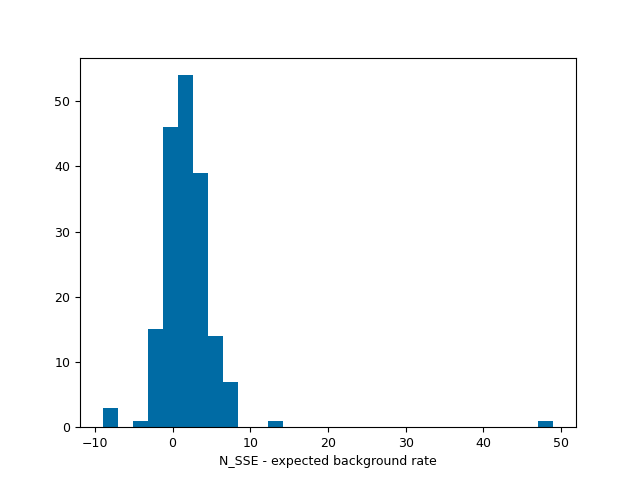

In [64]:
fig, ax = plt.subplots()
ax.hist(N_SSE-N_0,bins=30)
ax.set(
    xlabel = 'N_SSE - expected background rate',
)

In [ ]:
windows = np.logspace(1,3,100)
R = []
F = []
ALPHA = []
for i_window in windows:
    r, n_sse, n_o = [np.array(l) for l in in_vs_out(t=center_sequences(space_window=i_window, concatenate_output=False)[0])]
    R.append(np.nanmean(r))
    
    f = np.log(n_sse) - np.log(n_o)
    f = f[~np.isnan(f) & ~np.isinf(f)]
    f = np.mean(f)
    f = np.exp(f)
    F.append(np.mean(f))
    
    n_o = n_o[:,np.newaxis]
    a = np.linalg.lstsq(n_o, n_sse,rcond=None)[0]
    
    ALPHA.append(a)

/Users/kdascher/miniforge3/envs/torchETAS/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kdascher/miniforge3/envs/torchETAS/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


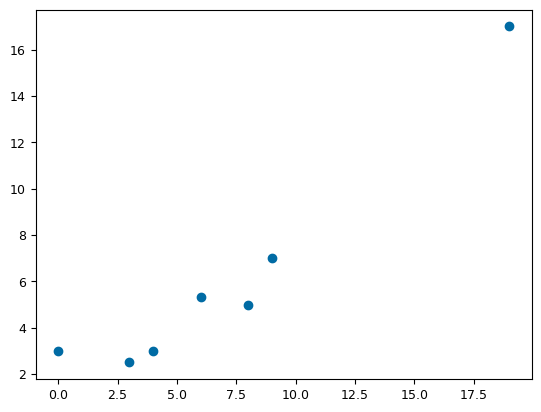

In [143]:
fig, ax = plt.subplots()
n_o = np.squeeze(n_o)
# ax.scatter(n_o,n_sse-n_o,s=1)

diff = []
for n in range(100):
    I = n_o==n
    diff.append(np.mean((n_sse)[I]))
    
ax.scatter(range(100),diff)

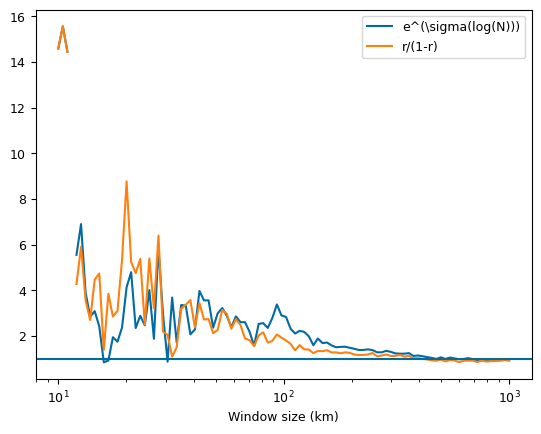

In [144]:
fig, ax = plt.subplots()
R = np.array(R)
# ax.plot(windows,R,c='k')

ax.plot(windows[:len(F)],F, label='e^(\sigma(log(N)))')
ax.plot(windows[:len(F)],R/(1-R), label='r/(1-r)')
# ax.plot(windows[:len(F)],ALPHA,label='least squares slope')
ax.set(
    xscale='log',
    xlabel='Window size (km)',
)
ax.axhline(1)
ax.legend()

1.5977957713154585
1.9095750656849733


/var/folders/nl/dmjw3blj27nd4c04v3dxnqw40000gn/T/ipykernel_92493/1003864088.py:13: RuntimeWarning: divide by zero encountered in divide
  f = np.array(N_SSE)/np.array(N_SSE-N_0)


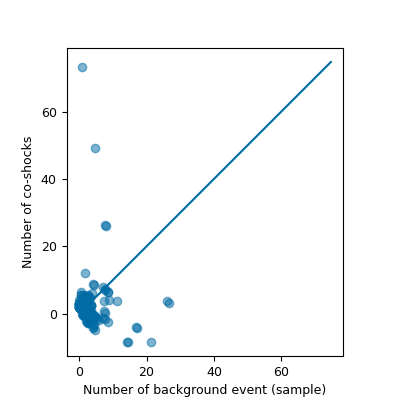

In [103]:
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(N_0,N_SSE-N_0, alpha=0.5,edgecolors=None)
ax.set(
    xlabel='Number of background event (sample)',
    ylabel='Number of co-shocks',
    aspect='equal'
)
minmax = [min(N_SSE+N_0),max(N_SSE+N_0)]
ax.plot(minmax,minmax)

np.polyfit(N_0, N_SSE-N_0,1)

f = np.array(N_SSE)/np.array(N_SSE-N_0)
f = f[~np.isinf(f) & ~np.isnan(f)]
print(np.mean(f))

mean_r = np.nanmean(r)
print(mean_r/(1-mean_r))

In [28]:
data_std = np.std(global_relative_times)
smoothing_bandwidth = SMOOTHING_BANDWIDTH_DAYS
bw = 0.1

number_of_times = 1000
time_array = np.linspace(-6/2, 6/2, number_of_times)

dens_co_kde = gaussian_kde(global_relative_times, bw_method=0.1, weights=global_weights)
dens_co_normalized = dens_co_kde(time_array)*7

regional_jackknife = []
for i in range(len(slowslip)):
    i_slowslip = [sse for n,sse in enumerate(slowslip) if n != i] # all but the ith slow slip event
    dt, dx, w = center_sequences(sum(i_slowslip[1:],i_slowslip[0]),time_window=5)
    regional_jackknife.append(
        gaussian_kde(dt, bw_method=bw, weights=w)(time_array)*7
    )
    
regional_dens = []
for dt,w in zip(regional_relative_times, regional_weights):
    regional_dens.append(
        gaussian_kde(dt, bw_method=bw, weights=w)(time_array)*7
    )

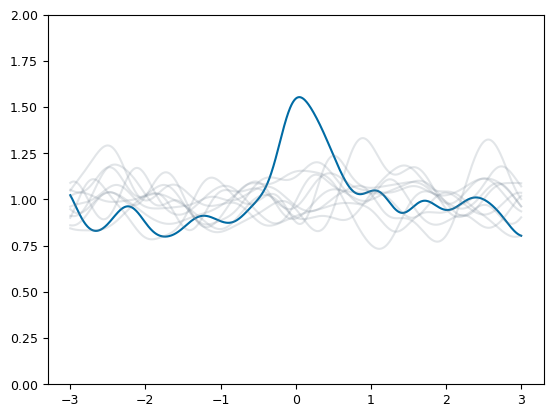

In [52]:
plt.plot(time_array,dens_co_normalized)
plt.ylim([0,2])

import copy
for _ in range(10):
    sse_copy = copy.deepcopy(all_slowslip)
    sse_copy.catalog['time'] = np.random.random(len(sse_copy)) * sse_copy.duration + sse_copy.start_time
    i_relative_times, _, i_weights = center_sequences(
        slowslipevents=sse_copy,time_window=7
    )
    i_dens_co_kde = gaussian_kde(i_relative_times, bw_method=0.1, weights=i_weights)
    i_dens_co_normalized = i_dens_co_kde(time_array)*7
    plt.plot(time_array,i_dens_co_normalized, c='slategrey', alpha=0.2)
    


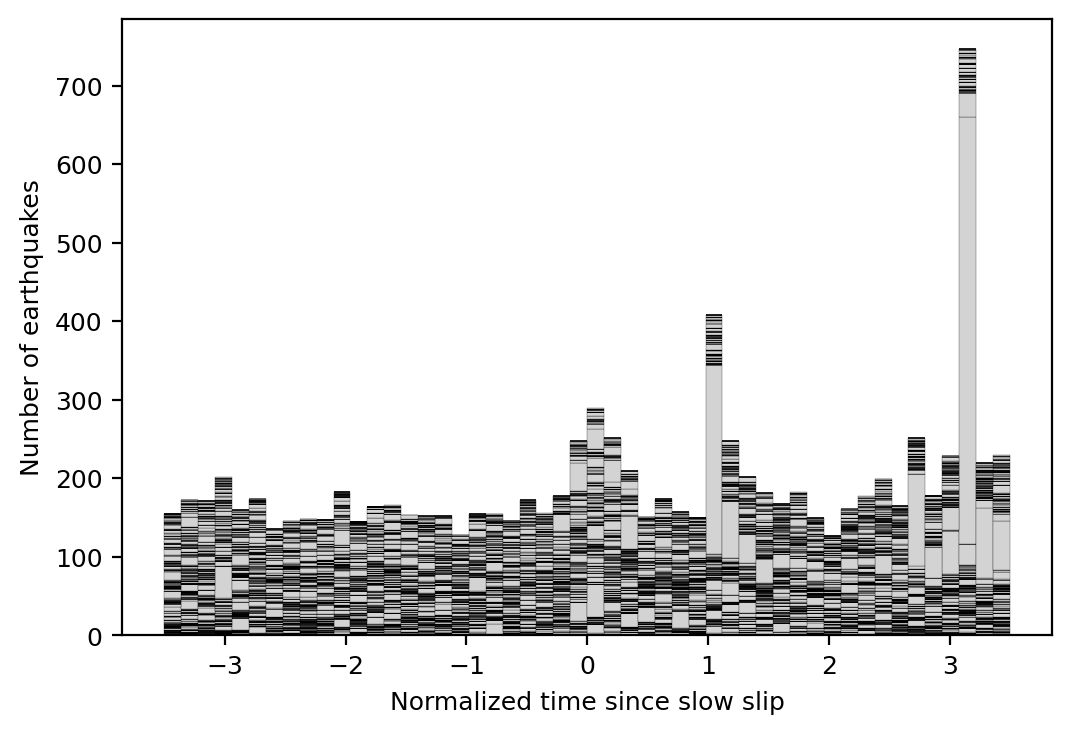

In [94]:
fig, ax = plt.subplots(figsize=(6,4))
ax.hist(
    raw_global_relative_times,
    50,
    histtype='barstacked',
    linewidth=0.1,
    color=['lightgrey']*(len(raw_global_relative_times)),
    edgecolor='k',
);
ax.set(
    ylabel='Number of earthquakes',
    xlabel='Normalized time since slow slip'
);
savefig('sandwich_plot')

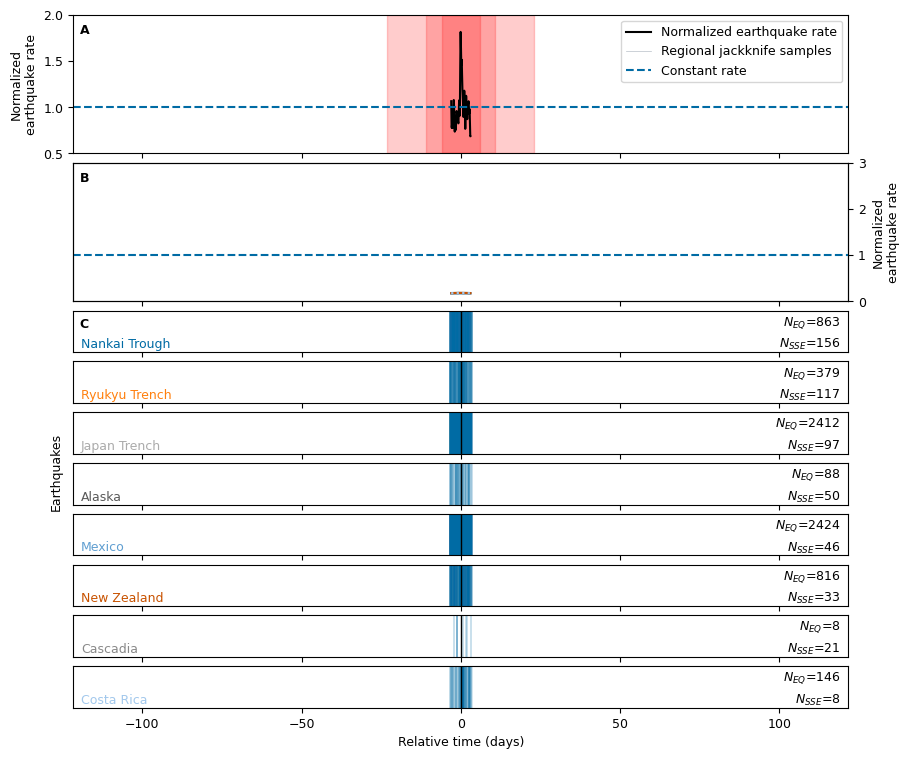

In [95]:
fig, AX = plt.subplots(
    len(slowslip)+2, 1, 
    figsize=(10,9), 
    sharex=True, 
    gridspec_kw=dict(hspace=0.15, height_ratios=2*[1]+len(slowslip)*[0.3]),
)


duration = all_slowslip.catalog['duration'].dropna().values/60/60/24
duration = duration[duration>0]
q = np.quantile(duration, [0.25,0.50,0.75])

# plot the 5, 50, and 95 percentile duration of the events
[
    AX[0].axvspan(-iq/2, iq/2, color='red', alpha=0.2)
    for iq in q
]


AX[0].plot(
    time_array, dens_co_normalized,
    color='k',
    label='Normalized earthquake rate'
)

lh = [
    AX[0].plot(
        time_array, regional_jackknife[i], 
        color='slategray', 
        lw=0.5, 
        alpha=0.5
    ) for i in range(len(slowslip))
]
lh[0][0].set_label('Regional jackknife samples')

AX[0].axhline(1,ls='--', label='Constant rate')
AX[0].legend(loc='upper right')
AX[0].set(
    ylim=[0.5,2],
    ylabel='Normalized\nearthquake rate',
)

AX[1].set(yticks=[])
axb = AX[1].twinx()
for i_regional_dens, dt in zip(regional_dens, regional_relative_times):
    axb.plot(
        time_array,
        i_regional_dens,
        label=f"KDE bandwidth: {smoothing_bandwidth} days", 
        ls=':' if len(dt)<200 else '-',
    )

axb.axhline(1,ls='--')
axb.set(
    ylim=[0,3],
    ylabel='Normalized\nearthquake rate',
)


for i, region, dt, i_window_indices, iax in zip(
    range(len(slowslip)), 
    slowslip, 
    regional_relative_times, 
    regional_window_indices, 
    AX[2:]
):
    sns.rugplot(
        dt, 
        ax=iax, 
        label=f'{region.name}', 
        height=1, 
        lw=0.3, 
        alpha=min(1,5/np.sqrt(len(dt)))
    ) 
    
    iax.set(
        yticks=[],
    )
    
    # calculate the seiscmic coupling?
    Mo_sse = (10**(3/2*region.catalog['mag']+9.1)).sum()
    
    unique_indices = np.unique(np.concatenate(i_window_indices))
    Mo_eq = (
        10**(3/2*local_earthquakes.catalog['mag'].values[unique_indices]+9.1)
    ).sum()
    
    coupling = Mo_eq/(Mo_sse+Mo_eq)
    
    # iax.text(0.01,0.9,'$\chi_{SSE}$='+ f'{coupling:.2f}',transform=iax.transAxes, ha='left', va='top', color='indianred')
    iax.text(0.01,0.1,region.region,transform=iax.transAxes,color=f'C{i}')
    iax.text(0.99,0.1,"$N_{SSE}$" + f"={len(region)}",transform=iax.transAxes, ha='right')
    iax.text(0.99,0.9,"$N_{EQ}$" + f"={len(dt)}",transform=iax.transAxes, ha='right', va='top', color='k')
    iax.axvline(0, color='k', lw=1)


AX[-1].set(
    xlabel='Relative time (days)',
    xlim=[-TIME_WINDOW/3,TIME_WINDOW/3],
)

AX[4].set_ylabel('Earthquakes', ha='right')

for n, ax in enumerate(AX[:3]):
    pos = [0.008, 0.86]
    if n==2:
        pos = [0.008, 0.6]
    ax.text(*pos, string.ascii_uppercase[n], transform=ax.transAxes, weight='bold')

savefig('stack')



Text(0.5, 0, 'Duration (days)')

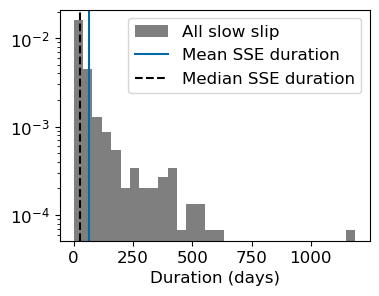

In [533]:
fig, ax = plt.subplots(figsize=(4,3))
ax.hist(all_slowslip.catalog['duration'].values/60/60/24, log=True, bins=30, color='k', alpha=0.5, density=True, label='All slow slip')
ax.axvline(np.nanmean(all_slowslip.catalog['duration'].values/60/60/24), label='Mean SSE duration')  
ax.axvline(np.nanmedian(all_slowslip.catalog['duration'].values/60/60/24),c='k',ls='--', label='Median SSE duration')
ax.legend()
ax.set_xlabel('Duration (days)')

## Spatial stacks

Text(0.5, 0, 'Estimated dimension (km)')

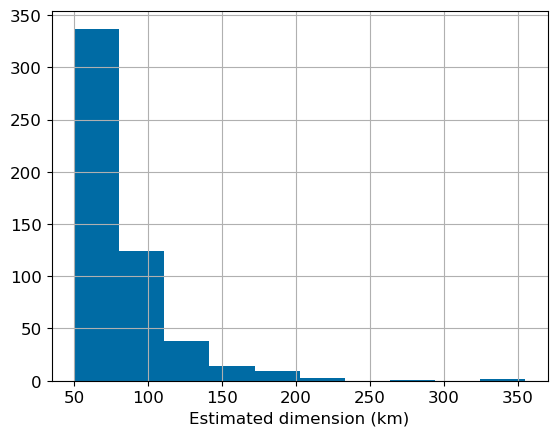

In [520]:
Scaling.magnitude_to_size(all_slowslip.catalog.mag,all_slowslip._stress_drop).hist()
plt.xlabel('Estimated dimension (km)')

In [521]:
T_pre = BACKGROUND_DURATION
buffer = BUFFER_TIME
T_event = REPRESENTATIVE_SSE_DURATION # all_slowslip.catalog['duration'].values/60/60/24 # days
W = SPACE_WINDOW_BIG # km
number_of_source_dimensions = 3 # for visualization purposes

# small wrapper function
def center_sequences_for_spatial_analysis(T, lag): 
    stack, w = center_sequences(time_window=T,space_window=W,lag=lag)[1:]
    I = ~np.any(np.abs(stack)>number_of_source_dimensions, axis=1)
    stack = stack[I,:]
    w = w[I]
    return [stack, w]

co_event_stack_combined, co_weights = center_sequences_for_spatial_analysis(T_event,0)
pre_event_stack_combined, pre_weights = center_sequences_for_spatial_analysis(T_pre,-T_pre/2 - T_event/2 - buffer)
post_event_stack_combined, post_weights = center_sequences_for_spatial_analysis(T_event,T_event/2)
    

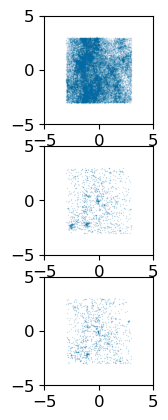

In [522]:

# Create a 2x2 grid with ratios [1, 1, 2] for the row heights
gs = mpl.gridspec.GridSpec(3, 1, )

levels = np.linspace(0, 0.075, 10)

# Subplot 1 - Top plot
ax1 = plt.subplot(gs[0, 0])  # First row, first column
ax1.scatter(pre_event_stack_combined[:,0], pre_event_stack_combined[:,1], s=1, alpha=0.1, linewidths=0)

# Subplot 2 - Middle plot
# share the x-axis with ax1
ax2 = plt.subplot(gs[1, 0], sharex=ax1)  # Second row, first column
ax2.scatter(co_event_stack_combined[:,0], co_event_stack_combined[:,1], s=1, alpha=0.2, linewidths=0)

# Subplot 3 - Bottom plot
ax3 = plt.subplot(gs[2, 0])  # third row, first column
ax3.scatter(post_event_stack_combined[:,0], post_event_stack_combined[:,1], s=1, alpha=0.2, linewidths=0)

for iax in [ax1,ax2,ax3]:
    iax.set(
        xlim=[-5,5],
        ylim=[-5,5],
        aspect='equal',
    )



In [523]:
# Define the bandwidth for smoothing
smoothing_bandwidth = 0.2

# Create the kernel density estimators
dens_pre_kde = gaussian_kde(pre_event_stack_combined.T, bw_method=smoothing_bandwidth/pre_event_stack_combined.T.std(ddof=1), weights=pre_weights)
dens_co_kde = gaussian_kde(co_event_stack_combined.T, bw_method=smoothing_bandwidth/co_event_stack_combined.T.std(ddof=1), weights=co_weights)
dens_post_kde = gaussian_kde(post_event_stack_combined.T, bw_method=smoothing_bandwidth/co_event_stack_combined.T.std(ddof=1), weights=post_weights)

# Define the range and grid
number_of_source_dimensions = 2
xmin, xmax = -number_of_source_dimensions, number_of_source_dimensions
ymin, ymax = -number_of_source_dimensions, number_of_source_dimensions
grid_size = 100

# Create a grid of points
xx, yy = np.meshgrid(np.linspace(xmin, xmax, grid_size), np.linspace(ymin, ymax, grid_size))
grid_points = np.column_stack((xx.flatten(), yy.flatten()))



# Evaluate the density ratio on the grid
dens_co = dens_co_kde(grid_points.T).reshape(xx.shape)
dens_pre = dens_pre_kde(grid_points.T).reshape(xx.shape)
dens_post = dens_post_kde(grid_points.T).reshape(xx.shape)
density_differences = dens_co-dens_pre
density_ratio = dens_co/dens_pre

## Ploting ratios

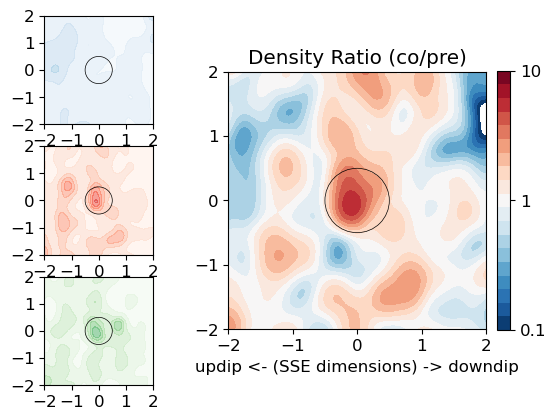

In [524]:

# Create a 2x2 grid with ratios [1, 1, 2] for the row heights
gs = mpl.gridspec.GridSpec(3, 2, width_ratios=[1.2, 2])

levels = np.linspace(0, 0.2, 10)

# Subplot 1 - Top plot
ax1 = plt.subplot(gs[0, 0])  # First row, first column
ax1.contourf(xx, yy, dens_pre, cmap='Blues',alpha=0.5, levels=levels)

# Subplot 2 - Middle plot
# share the x-axis with ax1
ax2 = plt.subplot(gs[1, 0], sharex=ax1)  # Second row, first column
ax2.contourf(xx, yy, dens_co, cmap='Reds',alpha=0.5, levels=levels)

# Subplot 3 - Bottom plot
ax3 = plt.subplot(gs[2, 0])  # third row, first column
ax3.contourf(xx, yy, dens_post, cmap='Greens',alpha=0.5, levels=levels)


# Subplot 3 - Right plot
ax4 = plt.subplot(gs[:, 1],  sharex=ax1)  # All rows, second column
ch = ax4.contourf(xx, yy, np.log10(density_ratio), levels=np.linspace(-1,1, 20), cmap='RdBu_r')
cax4 = plt.colorbar(ch, ax=ax4, fraction=0.046, pad=0.04)

cax4.set_ticks([-1, 0, 1])
cax4.set_ticklabels(['0.1', '1', '10'])
ax4.set(
    xlabel='updip <- (SSE dimensions) -> downdip',
    title='Density Ratio (co/pre)',
)

for iax in [ax1,ax2,ax3,ax4]:
    iax.add_artist(plt.Circle((0, 0), 0.5, color='k', fill=False, lw=0.5))
    iax.set(
        aspect='equal',
        xticks=[-2,-1,0,1,2],
        yticks=[-2,-1,0,1,2],
    );

## Plotting differences

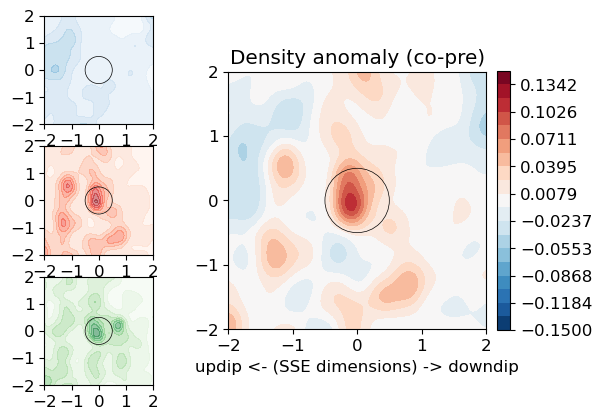

In [525]:

# Create a 2x2 grid with ratios [1, 1, 2] for the row heights
gs = mpl.gridspec.GridSpec(3, 2, width_ratios=[1.2, 2])

levels = np.linspace(0, 0.15, 10)

# Subplot 1 - Top plot
ax1 = plt.subplot(gs[0, 0])  # First row, first column
ax1.contourf(xx, yy, dens_pre, cmap='Blues',alpha=0.5, levels=levels)

# Subplot 2 - Middle plot
# share the x-axis with ax1
ax2 = plt.subplot(gs[1, 0], sharex=ax1)  # Second row, first column
ax2.contourf(xx, yy, dens_co, cmap='Reds',alpha=0.5, levels=levels)

# Subplot 3 - Bottom plot
ax3 = plt.subplot(gs[2, 0])  # third row, first column
ax3.contourf(xx, yy, dens_post, cmap='Greens',alpha=0.5, levels=levels)


# Subplot 3 - Right plot
ax4 = plt.subplot(gs[:, 1],  sharex=ax1)  # All rows, second column
ch = ax4.contourf(xx, yy, (density_differences), levels=np.linspace(-0.15,0.15, 20), cmap='RdBu_r')
cax4 = plt.colorbar(ch, ax=ax4, fraction=0.046, pad=0.04)

# cax4.set_ticks([-1, 0, 1])
# cax4.set_ticklabels(['0.1', '1', '10'])
ax4.set(
    xlabel='updip <- (SSE dimensions) -> downdip',
    title='Density anomaly (co-pre)',
)

for iax in [ax1,ax2,ax3,ax4]:
    iax.add_artist(plt.Circle((0, 0), 0.5, color='k', fill=False, lw=0.5))
    iax.set(
        aspect='equal',
        xticks=[-2,-1,0,1,2],
        yticks=[-2,-1,0,1,2],
    );

## Frequency of anomalies

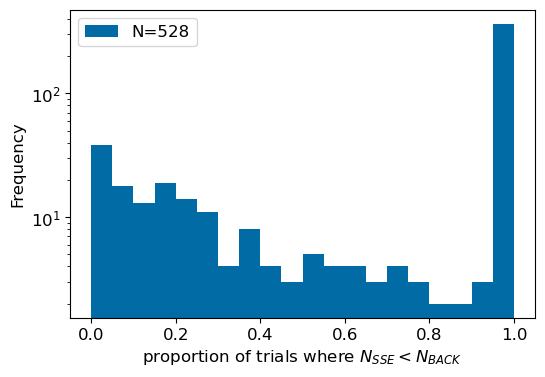

In [526]:
p_values, pre_time_lags, buffer_time_lags, co_time_lags = get_p_relative_to_back()
fig, ax = plt.subplots(1,1,figsize=(6,4))
th = 0.05
ax.hist(p_values, label=f'N={len(p_values)}', bins=20, log=True)
ax.set(xlabel='proportion of trials where $N_{SSE} < N_{BACK}$', ylabel='Frequency')
ax.legend()

Text(0.5, 0, 'number of earthquakes')

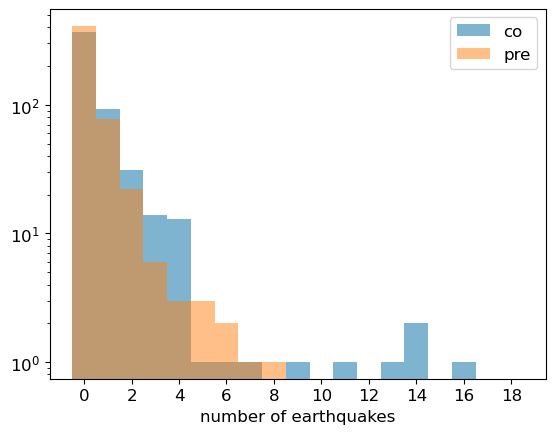

In [527]:
N = np.array([len(t) for t in co_time_lags])
N_pre = np.array([len(t) for t in pre_time_lags])
plt.hist(N,log=True, bins=np.arange(20)-0.5, alpha=0.5, label='co');
plt.hist(N_pre/(BACKGROUND_DURATION/REPRESENTATIVE_SSE_DURATION),log=True, bins=np.arange(20)-0.5,alpha=0.5,label='pre');
plt.legend()
plt.xticks(np.arange(20)[::2]);
plt.xlabel('number of earthquakes')

In [528]:
(N>0).sum()/len(N)

0.3068181818181818

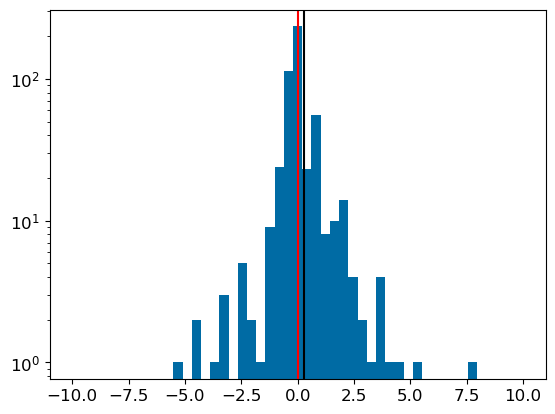

In [529]:
plt.hist((N-N_pre/(BACKGROUND_DURATION/REPRESENTATIVE_SSE_DURATION)),bins=np.linspace(-10,10))
plt.yscale('log')
plt.axvline(c='r')
plt.axvline((N-N_pre/(BACKGROUND_DURATION/REPRESENTATIVE_SSE_DURATION)).mean(),c='k')

In [530]:
(p_values<th).sum()/len(p_values)

0.07196969696969698

In [494]:
## Look at some samples where the p-value is low - which we interpret as a significant increase in the number of events:
I = np.where(p_values < th)[0]

In [495]:
len(I)

19

In [496]:
def kstest_sample(array, index):
    return kstest(np.delete(array, index), array[index])

/var/folders/nl/dmjw3blj27nd4c04v3dxnqw40000gn/T/ipykernel_53425/3628621298.py:33: RuntimeWarning: divide by zero encountered in divide
  moment_rate = 10**(1.5*all_slowslip.catalog.mag.values + 9.1)/all_slowslip.catalog.duration.values


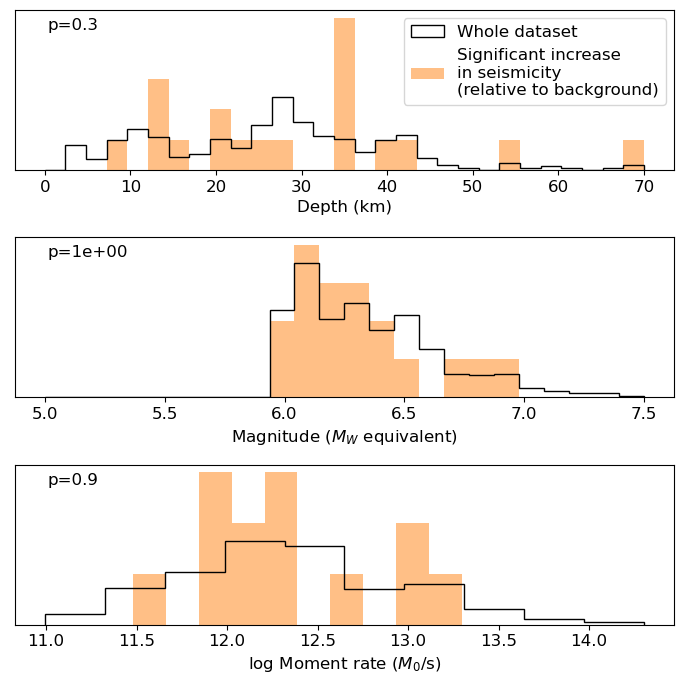

In [497]:
fig, AX = plt.subplots(3,1,figsize=(7,7))
whole_data_kwargs = dict(
    histtype='step',
    color='k',
    label='Whole dataset',
    density=True,
)
outlier_data_kwargs = dict(
     alpha=0.5, label='Significant increase\nin seismicity \n(relative to background)', color='C1',density=True,
)

ax = AX[0]
bins = np.linspace(0,70,30)
ax.hist(all_slowslip.catalog.depth.values,bins=bins, **whole_data_kwargs)
ax.hist(all_slowslip.catalog.depth.values[I], bins=bins, **outlier_data_kwargs)
# sns.rugplot(all_slowslip.catalog.depth.values[I], color='r', height=0.25, lw=0.5, ax=ax, label='Significant increase\nin seismicity \n(relative to background)')
ax.set(
    xlabel='Depth (km)',
)

ax.legend()

ax = AX[1]
bins = np.linspace(5,7.5,25)
ax.hist(all_slowslip.catalog.mag.values,bins=bins, **whole_data_kwargs)
ax.hist(all_slowslip.catalog.mag.values[I], bins=bins, **outlier_data_kwargs)
# sns.rugplot(all_slowslip.catalog.mag.values[I], color='r', height=0.25, lw=0.5, ax=ax,)
ax.set(
    xlabel='Magnitude ($M_W$ equivalent)',
)
ax = AX[2]

moment_rate = 10**(1.5*all_slowslip.catalog.mag.values + 9.1)/all_slowslip.catalog.duration.values
I_nan = (~np.isnan(moment_rate)) & (~np.isinf(moment_rate))
ax.hist(np.log10(moment_rate[I_nan]), **whole_data_kwargs)
ax.hist(np.log10(moment_rate[I][I_nan[I]]), **outlier_data_kwargs)
ax.set_xlabel('log Moment rate ($M_0$/s)')


[
    iax.text(0.05,0.95, f'p={kstest_sample(iarray,I)[1]:0.1}', transform=iax.transAxes, va='top', ha='left') 
    for iax, iarray in zip(AX, [all_slowslip.catalog.depth.values, all_slowslip.catalog.mag.values, moment_rate])
]

[iax.set_yticks([]) for iax in AX]

plt.tight_layout()
savefig('outliers')

### All places that have slow slip events seem to have some that are abnorally productive

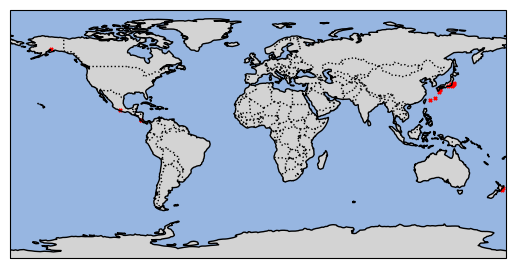

In [498]:
_, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
usemap_proj = ccrs.PlateCarree()
# set appropriate extents: (lon_min, lon_max, lat_min, lat_max)
extent = [-180,180,-90,90]

ax.set_extent(
    extent,
    crs=ccrs.PlateCarree(),
)

ax.add_feature(cfeature.LAND, color="lightgray")
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")



ax.scatter(
    all_slowslip.catalog.lon.values[I],
    all_slowslip.catalog.lat.values[I],
    marker='x',
    s=5,
    c='r',
)
savefig('record_map')



In [499]:
all_slowslip.catalog.iloc[I].groupby('region').count().lat

region
Alaska           1
Costa Rica       2
Japan Trench     7
Mexico           1
Nankai Trough    3
New Zealand      2
Ryukyu Trench    3
Name: lat, dtype: int64

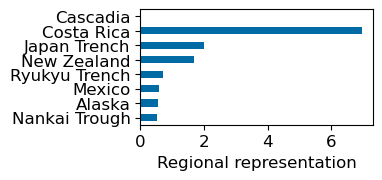

In [500]:
df_groups = ((all_slowslip.catalog.iloc[I].groupby('region').count().lat/all_slowslip.catalog.groupby('region').count().lat)/(sum(p_values < th)/len(p_values))).sort_values()
df_groups.plot(kind='barh', figsize=(3,1.5))
plt.ylabel('')
plt.xlabel('Regional representation')
savefig('regional bias')

A somewhat paradoxical results is that there are on average more earthquakes in the background period than during slow slip events. It is paradoxical because the periods with slow slip are nonetheless abnormal in having more seismicity than a random window in the preceding period. I beleive the only way to reconcile these two results is to suggest that, in general, seismicity prior to slow slip events tends to be quite clustered such that most window end up less productive the period with slow slip events with primarily is accopanied by a more reliable subtle increase in the background rate of seismicity. This might also indicate that in general the seismicity rate, accross then entire dataset is decreasing with time. This is inference is testable by looking at the seismicity rate in the period following the slow slip events.

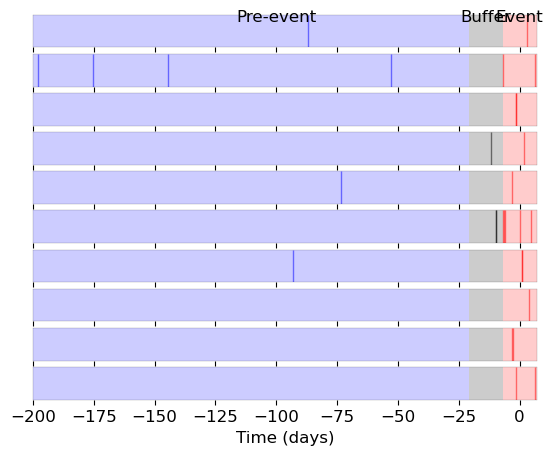

In [501]:
I = np.where(p_values<0.05)[0]
N = min(len(I),10)
t0 = -200
fig, ax = plt.subplots(N,1, figsize=(6.5,5), sharex=True)
for iax,i in zip(ax,I):
    shared_kwargs = dict(height=1, alpha=0.5, ax=iax)
    [sns.rugplot(dt[i],color=c, **shared_kwargs) for dt,c in zip([pre_time_lags, buffer_time_lags, co_time_lags], ['b','k','r'])]
    
    [
        iax.axvspan(x1,x2, color=c, alpha=0.2, lw=0) 
        for x1,x2,c in zip(
            [-T_pre-buffer-T_event/2, -T_event/2-buffer, -T_event/2],
            [-T_event/2-buffer, -T_event/2, T_event/2],
            ['b','k','r'],
        )
    ]
    iax.set(yticklabels=[], xlim=[t0, T_event/2], ylabel='', yticks=[])
    
[
    ax[0].text(x,1, va='bottom', ha='center', s=s) for x,s in zip(
        [0, -T_event/2-buffer/2, t0/2],
        ['Event', 'Buffer', 'Pre-event']
    )
]
ax[-1].set(xlabel='Time (days)')

[[x.set_linewidth(0.1) for x in iax.spines.values()] for iax in ax];
savefig('most_triggered_earthquakes')